In [24]:
import os
import tarfile
import requests
from google.colab import drive
import numpy as np
import pandas as pd
import random
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torchaudio import transforms
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [25]:
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/UrbanSound8K"
dataset_path = os.path.join(drive_path, "UrbanSound8K.tar.gz")
extract_path = os.path.join(drive_path, "UrbanSound8K")

os.makedirs(drive_path, exist_ok = True)

local_path = "/content/UrbanSound8K"
if not os.path.exists(local_path):
    os.symlink(extract_path, local_path)

if not os.path.exists(extract_path):
    print("Dataset not found in Drive. Downloading...")

    url = "https://goo.gl/8hY5ER"
    response = requests.get(url, stream=True)
    with open(dataset_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall(path=drive_path)

print("Dataset is ready at:", extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset is ready at: /content/drive/MyDrive/UrbanSound8K/UrbanSound8K


In [26]:
dataset_folder = extract_path
print("Folders in UrbanSound8K:", os.listdir(dataset_folder))

Folders in UrbanSound8K: ['.DS_Store', 'audio', 'FREESOUNDCREDITS.txt', 'metadata', 'UrbanSound8K_README.txt']


In [27]:
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata_file, audio_dir, max_length=16000, transform=None):
        self.metadata = pd.read_csv(metadata_file)  # Load CSV
        self.audio_dir = audio_dir
        self.transform = transform
        self.max_length = max_length  # Set max audio length in samples

    def __len__(self):
        return len(self.metadata)

    def pad_or_truncate(self, waveform):
        """Ensures all waveforms have the same number of samples."""
        num_samples = waveform.shape[1]

        if num_samples < self.max_length:  # Pad if too short
            pad_amount = self.max_length - num_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        else:  # Truncate if too long
            waveform = waveform[:, :self.max_length]

        return waveform

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]  # Get row from DataFrame

        # Extract filename, fold, and label
        filename = row["slice_file_name"]
        fold = row["fold"]
        label = row["classID"]

        # Construct full path to audio file
        audio_path = os.path.join(self.audio_dir, f"fold{fold}", filename)

        # Load the audio file
        waveform, sample_rate = torchaudio.load(audio_path)

         # Convert stereo to mono (if necessary)
        if waveform.shape[0] > 1:  # If it has more than 1 channel
            waveform = torch.mean(waveform, dim=0, keepdim=True)  # Convert to mono

        # Normalize and fix length
        waveform = self.pad_or_truncate(waveform)

        return waveform, sample_rate, torch.tensor(label, dtype=torch.long)


In [28]:
metadata_file = "/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
audio_dir = "/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio"

dataset = UrbanSoundDataset(metadata_file, audio_dir, max_length=16000)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

all_waveforms = []
all_labels = []

print("Processing dataset...")
for batch in tqdm(dataloader, desc="Loading Data", unit="batch"):
    waveform, sample_rate, label = batch

    all_waveforms.append(waveform)
    all_labels.append(label)

all_waveforms = torch.cat(all_waveforms, dim=0)
all_labels = torch.cat(all_labels, dim=0)

Processing dataset...


Loading Data: 100%|██████████| 546/546 [02:58<00:00,  3.05batch/s]


In [29]:
# Hann Window
def hann_window(n):
    return 0.5 * (1 - torch.cos(2 * torch.pi * torch.arange(n) / (n - 1)))

# Hamming Window
def hamming_window(n):
    return 0.54 - 0.46 * torch.cos(2 * torch.pi * torch.arange(n) / (n - 1))

# Rectangular Window
def rectangular_window(n):
    return torch.ones(n)

In [30]:
def apply_window(waveform, window_fn):
    n = waveform.shape[1]
    window = window_fn(n).to(waveform.device)
    return waveform * window

In [31]:
def compute_spectrogram(waveform, window_fn, n_fft=512, hop_length=256):
    windowed_waveform = apply_window(waveform, window_fn)

    # Compute STFT
    stft = torch.stft(
        windowed_waveform,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=n_fft,
        window=torch.hann_window(n_fft).to(waveform.device),
        return_complex=True,
    )

    # Convert to magnitude spectrogram
    spectrogram = torch.abs(stft)

    return spectrogram

In [32]:
def plot_spectrogram(spectrogram, title):
    spectrogram_np = spectrogram.squeeze().cpu().numpy()

    fig = go.Figure(data=go.Heatmap(
        z=spectrogram_np,
        colorscale='Viridis',
        colorbar=dict(title='Magnitude'),
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Time Frames',
        yaxis_title='Frequency Bins',
    )

    fig.show()

In [33]:
# Compute and store spectrograms
hann_spectrograms = []
hamming_spectrograms = []
rectangular_spectrograms = []

print("Generating spectrograms...")
for waveform in tqdm(all_waveforms, desc="Processing Audio", unit="file"):
    hann_spectrograms.append(compute_spectrogram(waveform, hann_window))
    hamming_spectrograms.append(compute_spectrogram(waveform, hamming_window))
    rectangular_spectrograms.append(compute_spectrogram(waveform, rectangular_window))

# Convert to tensors
hann_spectrograms = torch.stack(hann_spectrograms)
hamming_spectrograms = torch.stack(hamming_spectrograms)
rectangular_spectrograms = torch.stack(rectangular_spectrograms)

# Select one sample for visualization
sample_idx = 0  # Change this index to visualize a different sample
plot_spectrogram(hann_spectrograms[sample_idx], "Hann Window Spectrogram")
plot_spectrogram(hamming_spectrograms[sample_idx], "Hamming Window Spectrogram")
plot_spectrogram(rectangular_spectrograms[sample_idx], "Rectangular Window Spectrogram")


Generating spectrograms...


Processing Audio: 100%|██████████| 8732/8732 [00:14<00:00, 598.70file/s]


In [34]:
lr = 0.001
batch_size = 32
num_epochs = 20

In [35]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = None  # Will initialize dynamically
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            input_size = x.shape[1]
            self.fc1 = nn.Linear(input_size, 128).to(x.device)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [39]:
class SpectrogramDataset(Dataset):
    def __init__(self, spectrograms, labels):
        if spectrograms.ndim == 3:
            spectrograms = spectrograms.unsqueeze(1)
        self.spectrograms = spectrograms
        self.labels = labels

    def __len__(self):
        return self.spectrograms.shape[0]

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

In [40]:
def train_model(spectrograms, labels, title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = SpectrogramDataset(spectrograms, labels)
    train_size = int(0.8 * len(dataset))  # 80% train, 20% validation
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = AudioCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    val_accuracies = []  # Store accuracy per epoch

    for epoch in range(num_epochs):
        model.train()
        for spectrograms, labels in train_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for spectrograms, labels in val_loader:
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                outputs = model(spectrograms)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)  # Store accuracy for this epoch
        print(f"{title} | Epoch {epoch+1} | Validation Accuracy: {accuracy:.4f}")

    # Plot epoch vs. validation accuracy
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=title)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Epoch vs. Validation Accuracy ({title})")
    plt.legend()
    plt.grid()
    plt.show()

    return val_accuracies[-1]  # Return final accuracy


=== Training with Hann Window Spectrograms ===
Hann Window | Epoch 1 | Validation Accuracy: 0.3297
Hann Window | Epoch 2 | Validation Accuracy: 0.4070
Hann Window | Epoch 3 | Validation Accuracy: 0.4448
Hann Window | Epoch 4 | Validation Accuracy: 0.4677
Hann Window | Epoch 5 | Validation Accuracy: 0.4694
Hann Window | Epoch 6 | Validation Accuracy: 0.4877
Hann Window | Epoch 7 | Validation Accuracy: 0.5060
Hann Window | Epoch 8 | Validation Accuracy: 0.5163
Hann Window | Epoch 9 | Validation Accuracy: 0.5398
Hann Window | Epoch 10 | Validation Accuracy: 0.5404
Hann Window | Epoch 11 | Validation Accuracy: 0.5363
Hann Window | Epoch 12 | Validation Accuracy: 0.5484
Hann Window | Epoch 13 | Validation Accuracy: 0.5432
Hann Window | Epoch 14 | Validation Accuracy: 0.5570
Hann Window | Epoch 15 | Validation Accuracy: 0.5375
Hann Window | Epoch 16 | Validation Accuracy: 0.5272
Hann Window | Epoch 17 | Validation Accuracy: 0.5598
Hann Window | Epoch 18 | Validation Accuracy: 0.5587
Hann Wi

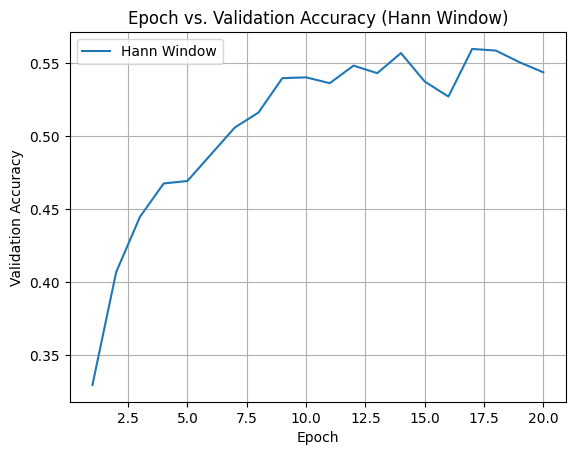


=== Training with Hamming Window Spectrograms ===
Hamming Window | Epoch 1 | Validation Accuracy: 0.3475
Hamming Window | Epoch 2 | Validation Accuracy: 0.4253
Hamming Window | Epoch 3 | Validation Accuracy: 0.4293
Hamming Window | Epoch 4 | Validation Accuracy: 0.4596
Hamming Window | Epoch 5 | Validation Accuracy: 0.4614
Hamming Window | Epoch 6 | Validation Accuracy: 0.4860
Hamming Window | Epoch 7 | Validation Accuracy: 0.4774
Hamming Window | Epoch 8 | Validation Accuracy: 0.4551
Hamming Window | Epoch 9 | Validation Accuracy: 0.5180
Hamming Window | Epoch 10 | Validation Accuracy: 0.5077
Hamming Window | Epoch 11 | Validation Accuracy: 0.5220
Hamming Window | Epoch 12 | Validation Accuracy: 0.5289
Hamming Window | Epoch 13 | Validation Accuracy: 0.5157
Hamming Window | Epoch 14 | Validation Accuracy: 0.5341
Hamming Window | Epoch 15 | Validation Accuracy: 0.5386
Hamming Window | Epoch 16 | Validation Accuracy: 0.5346
Hamming Window | Epoch 17 | Validation Accuracy: 0.5472
Hammin

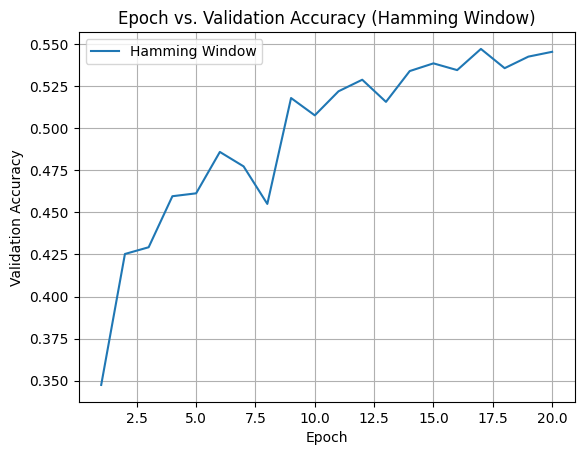


=== Training with Rectangular Window Spectrograms ===
Rectangular Window | Epoch 1 | Validation Accuracy: 0.3875
Rectangular Window | Epoch 2 | Validation Accuracy: 0.4276
Rectangular Window | Epoch 3 | Validation Accuracy: 0.4219
Rectangular Window | Epoch 4 | Validation Accuracy: 0.4522
Rectangular Window | Epoch 5 | Validation Accuracy: 0.4699
Rectangular Window | Epoch 6 | Validation Accuracy: 0.4814
Rectangular Window | Epoch 7 | Validation Accuracy: 0.5060
Rectangular Window | Epoch 8 | Validation Accuracy: 0.5169
Rectangular Window | Epoch 9 | Validation Accuracy: 0.5123
Rectangular Window | Epoch 10 | Validation Accuracy: 0.5089
Rectangular Window | Epoch 11 | Validation Accuracy: 0.5192
Rectangular Window | Epoch 12 | Validation Accuracy: 0.5238
Rectangular Window | Epoch 13 | Validation Accuracy: 0.5186
Rectangular Window | Epoch 14 | Validation Accuracy: 0.5255
Rectangular Window | Epoch 15 | Validation Accuracy: 0.5306
Rectangular Window | Epoch 16 | Validation Accuracy: 0

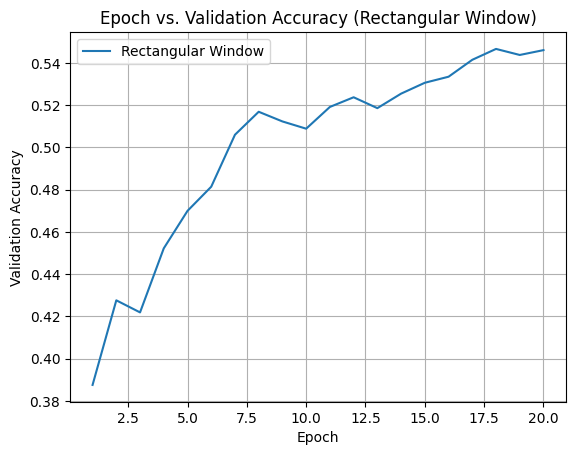

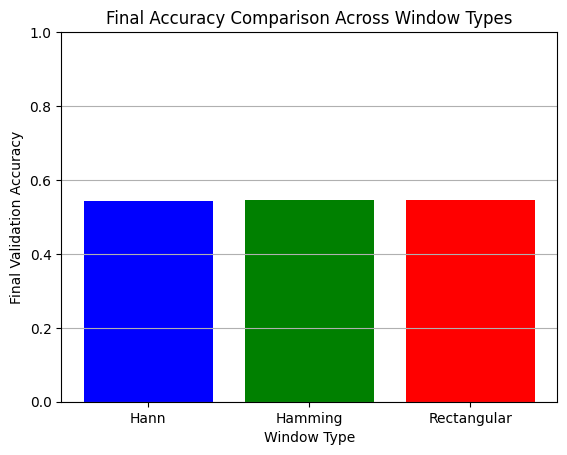

In [42]:
# Run training for each window type
print("\n=== Training with Hann Window Spectrograms ===")
accuracy_hann = train_model(hann_spectrograms, all_labels, "Hann Window")

print("\n=== Training with Hamming Window Spectrograms ===")
accuracy_hamming = train_model(hamming_spectrograms, all_labels, "Hamming Window")

print("\n=== Training with Rectangular Window Spectrograms ===")
accuracy_rect = train_model(rectangular_spectrograms, all_labels, "Rectangular Window")

# Final accuracy comparison plot
window_types = ["Hann", "Hamming", "Rectangular"]
accuracies = [accuracy_hann, accuracy_hamming, accuracy_rect]

plt.bar(window_types, accuracies, color=["blue", "green", "red"])
plt.xlabel("Window Type")
plt.ylabel("Final Validation Accuracy")
plt.title("Final Accuracy Comparison Across Window Types")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()